In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tiles3 as tc
from IPython.display import clear_output

In [31]:
class TileCoder:

    def __init__(self, iht_size, num_tilings, num_tiles):
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles

    def get_tiles(self, state):
        position, velocity, angle, angular = state
        position_min, position_max = -2.4, 2.4
        velocity_min, velocity_max = -3, 3
        angle_min, angle_max = -0.2095, 0.2095
        angular_min, angular_max = -6, 6
        position_scale = self.num_tiles / (position_max - position_min)
        velocity_scale = self.num_tiles / (velocity_max - velocity_min)
        angle_scale = self.num_tiles / (angle_max - angle_min)
        angular_scale = self.num_tiles / (angular_max - angular_min)
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale,
                                                      angle * angle_scale,
                                                      angular * angular_scale])
        return np.array(tiles)

class SarsaAgent:

    def __init__(self):
        self.iht_size = 4096
        self.num_tilings = 8
        self.num_tiles = 8
        self.epsilon = 0.1
        self.gamma = 1.0
        self.alpha = 0.5 / self.num_tilings
        self.num_actions = 2
        self.w = np.zeros([self.num_actions, self.iht_size])
        self.tilecoder = TileCoder(self.iht_size, self.num_tilings, self.num_tiles)
        self.last_action = None
        self.last_tiles = None

    def select_action(self, tiles):
        action_values = self.w[:, tiles].sum(axis=1)
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = action_values.argmax()
        action_value = action_values[action]
        return action, action_value
    
    def start(self, state):
        tiles = self.tilecoder.get_tiles(state)
        action, action_value = self.select_action(tiles)
        self.last_action = action
        self.last_tiles = tiles.copy()
        return self.last_action

    def step(self, state, reward):
        tiles = self.tilecoder.get_tiles(state)
        action, action_value = self.select_action(tiles)
        last_action_value = self.w[self.last_action][self.last_tiles].sum()
        delta = reward + self.gamma * action_value - last_action_value
        self.w[self.last_action][self.last_tiles] += self.alpha * delta
        self.last_action = action
        self.last_tiles = tiles.copy()
        return self.last_action

    def end(self, reward):
        last_action_value = self.w[self.last_action][self.last_tiles].sum()
        delta = reward - last_action_value
        self.w[self.last_action][self.last_tiles] += self.alpha * delta

In [38]:
def plot(num_steps_list):
    plt.figure(figsize=(5, 4))
    plt.plot(num_steps_list, color='green')
    plt.grid(alpha=0.2)
    plt.xlabel('episode')
    plt.ylabel('num_steps')
    plt.show()

In [ ]:
env = gym.make('CartPole-v1', render_mode='human')
agent = SarsaAgent()
num_steps_list = []

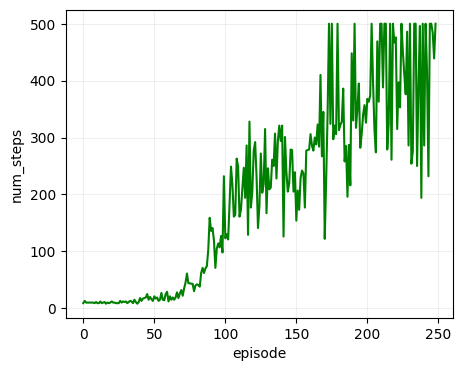

In [39]:
num_episodes = 500
plot_episode = 1

for episode in range(num_episodes):
    state, _ = env.reset()
    action = agent.start(state)
    done, win = False, False
    num_steps = 0
    while not done:
        state, reward, done, win, _ = env.step(action)
        action = agent.step(state, reward)
        num_steps += 1
        if done or win:
            agent.end(reward)
            break
        
    num_steps_list.append(num_steps)
    if episode % plot_episode == 0:
        plot(num_steps_list)
        clear_output(wait=True)